## Setup imports

In [1]:
import nibabel as nib
from tqdm import tqdm
import os
import shutil

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    SpatialPadd,
    LambdaD,
    EnsureChannelFirstd,
)
from monai.config import print_config
from monai.metrics import DiceMetric, HausdorffDistanceMetric, SurfaceDistanceMetric
from monai.networks.nets import SwinUNETR
from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

import torch

# import argparse
import sys
import csv
import numpy as np
import datetime
import matplotlib.pyplot as plt

print_config()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python312\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.2
Nibabel version: 5.3.2
scikit-image version: 0.25.1
scipy version: 1.15.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cpu
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

## Setup arguments

In [2]:
# parser = argparse.ArgumentParser(description="Train a MONAI model with arguments")

# # required arguments
# parser.add_argument("-exp_name", type=str, required=True, help="Name of the experiment")
# parser.add_argument("-json_dir", type=str, required=True, help="Path to the dataset JSON file")

# # optional arguments
# parser.add_argument("-max_iterations", type=int, default=30000, help="Maximum number of training iterations")
# parser.add_argument("-size_patch", nargs=3, type=int, default=[96,96,96], help="Spatial size of training patches (x, y, z)")
# parser.add_argument("-dim_voxel", nargs=3, type=float, default=[1.5,1.5,2.0], help="Voxel spacing in millimeters (x, y, z)")
# parser.add_argument("-size_batch", type=int, default=1, help="Batch size used for training and validation")
# parser.add_argument("-size_cache_train", type=int, default=24, help="Number of training samples to cache in memory")
# parser.add_argument("-size_cache_valid", type=int, default=6, help="Number of validation samples to cache in memory")
# parser.add_argument("-channels_out", type=int, default=14, help="Number of output channels (e.g., number of classes)")
# parser.add_argument("-prob_drop", type=float, default=0.0, help="Dropout probability for regularization")
# parser.add_argument("-num_samples", type=int, default=4, help="Number of training samples to load per iteration")
# parser.add_argument("-postfix", type=str, default="", help="Postfix to append to the experiment name")
# parser.add_argument("-eval_num", type=int, default=1, help="Number of validation evaluations per epoch")
# parser.add_argument("-intensity_range", nargs=2, type=float, default=[-175, 250], help="Range for input intensity normalization")
# parser.add_argument("-fg_class", nargs='+', type=int, default=[1], help="List of foreground class indices for segmentation")

# # personalization mode
# parser.add_argument("--personalize", action="store_true", help="Enable personalization mode with limited training samples")

# args = parser.parse_args()

# Required arguments (set with example values)
exp_name = 'First trial'
json_dir = 'J:/JChun/data/nnUNet_raw_data_base/Dataset208_Pancreas_Cyst/dataset_pancreas_Morfeus_fold0.json'  # e.g., dataset JSON file path

# Optional arguments (using default values)
max_iterations = 10 # 30000
size_patch = [96, 96, 96]
dim_voxel = [1.5, 1.5, 2.0]
size_batch = 1
size_cache_train = 10 # 150
size_cache_valid = 1 # 50
channels_out = 2
prob_drop = 0.05
num_samples = 1 # 10
postfix = ""
eval_num = 1
a_min, a_max = [-175, 250]
fg_class = [1, 2]

# Personalization mode
personalize = False

## Setup data directory

In [3]:
root_dir = '../! history'
if not os.path.exists(root_dir):
    os.makedirs(root_dir, exist_ok=True)
    print(f"Created root directory: {root_dir}")

exp_path = os.path.join(root_dir, exp_name)
os.makedirs(exp_path, exist_ok=True)
print(f"Created experiment directory: {exp_path}")

# Timestamped backup of the original training script / K8s YAML for traceability
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
shutil.copy('./swin_unetr_btcv_segmentation_3d_singleCh.py', f"{exp_path}/swin_unetr_btcv_segmentation_3d_singleCh_{timestamp}.py")
if personalize:
    shutil.copy('./job-f0-0.yaml', f"{exp_path}/job-f0-0_{timestamp}.yml")
else:
    shutil.copy('../monai_k8s_train.yml', f"{exp_path}/monai_k8s_train_{timestamp}.yml")



Created experiment directory: ../! history\First trial


FileNotFoundError: [Errno 2] No such file or directory: '../monai_k8s_train.yml'

## Setup transforms for training and validation

In [ ]:
def make_fg_mask(class_list):
    # Returns a function that creates a foreground mask given a list of class indices
    def fg_func(label):
        # Create a boolean mask where any voxel matching the specified classes is True
        mask = torch.zeros_like(label, dtype=torch.bool)
        for c in class_list:
            mask |= (label == c)
        # Convert boolean mask to uint8 format (0 or 1)
        return mask.to(torch.uint8)
    return fg_func

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=False),
        EnsureChannelFirstd(keys=["image", "label"],channel_dim='no_channel'),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=a_min,
            a_max=a_max,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=dim_voxel,
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            keys=["image", "label"],
            spatial_size=size_patch,
            method="symmetric",
        ),
        EnsureTyped(keys=["image", "label"], device="cpu", track_meta=False),
        LambdaD(
            keys="label",
            func=make_fg_mask(fg_class)
        ),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=size_patch,
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=False),
        EnsureChannelFirstd(keys=["image", "label"],channel_dim='no_channel'),
        ScaleIntensityRanged(keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=dim_voxel,
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            keys=["image", "label"],
            spatial_size=size_patch,
            method="symmetric",
        ),
        EnsureTyped(keys=["image", "label"], device="cpu", track_meta=True),
        LambdaD(
            keys="label",
            func=make_fg_mask(fg_class)
        ),
    ]
)



monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


## Dataset and format in the folder

In [ ]:
train_dicts = load_decathlon_datalist(json_dir, True, "training")
val_dicts = load_decathlon_datalist(json_dir, True, "validation")

# Logs
if personalize:    
    postfix_suffix = f"_{postfix}" if postfix else ""
    results_dir = os.path.join(exp_path, f"results_personalized{postfix_suffix}")
    
    img_name = os.path.split(val_dicts[0]["image"])[1].replace('.nii.gz','')
    print(img_name)
    model_path = os.path.join(results_dir, f"best_metric_model_personalized_{img_name}.pth")
    log_file_path = os.path.join(results_dir, "output_personalized_" + img_name + ".log")
    csv_path = os.path.join(results_dir, "validation_dsc_personalized_" + img_name + ".csv")
else:
    postfix_suffix = f"_{postfix}" if postfix else ""
    results_dir = os.path.join(exp_path, f"results{postfix_suffix}")
    
    log_file_path = os.path.join(results_dir, "output.log")
    csv_path = os.path.join(results_dir, "validation_dsc.csv")

os.makedirs(results_dir, exist_ok=True)
log_file = open(log_file_path, "w")

sys.stdout = log_file
sys.stderr = log_file

train_ds = CacheDataset(
    data=train_dicts,
    transform=train_transforms,
    cache_num=size_cache_train,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=size_batch, shuffle=True)
val_ds = CacheDataset(data=val_dicts, transform=val_transforms, cache_num=size_cache_valid, cache_rate=1.0, num_workers=4)
val_ds = val_ds[:1] # for testing purposes, use only one validation sample
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=size_batch)

# Disable global MetaTensor tracking to avoid unnecessary overhead during random transforms
set_track_meta(False)

## Check data shape and visualize

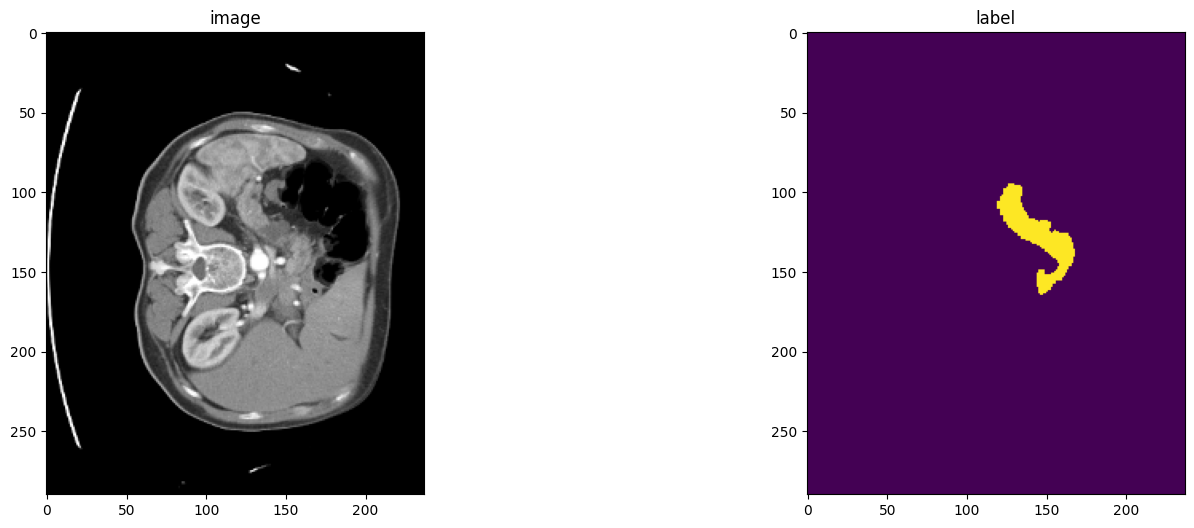

In [ ]:
slice_map = {
    "img0001_0000.nii.gz": 50,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

### Create Swin UNETR model

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

model = SwinUNETR(
    img_size=size_patch,
    in_channels=1,
    out_channels=channels_out,
    feature_size=48,
    drop_rate = prob_drop,
    attn_drop_rate = prob_drop,
    # dropout_path_rate = prob_drop,
    use_checkpoint=True,
).to(device)

### Initialize Swin UNETR encoder from self-supervised pre-trained weights

In [ ]:
# uncomment to download the pre-trained weights
# !wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

if personalize:
    model.load_state_dict(torch.load(os.path.join(os.path.join(exp_path, "results"), "best_metric_model.pth")))
    print("Using baseline model weights !")
else:
    weight = torch.load("../model_swinvit.pt")
    model.load_from(weights=weight)
    print("Using pretrained self-supervied Swin UNETR backbone weights !")

### Optimizer and loss function

In [ ]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [ ]:
def enable_dropout(model):
    """Force dropout to remain active even after model.eval()"""
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout) or isinstance(m, torch.nn.Dropout2d) or isinstance(m, torch.nn.Dropout3d):
            m.train()

def validation(epoch_iterator_val):
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            
            # Set the model to evaluation mode (disables BatchNorm and Dropout)
            model.eval()
            if personalize:
                # Re-enable dropout layers during evaluation for Monte-Carlo Dropout sampling
                enable_dropout(model)
                # Number of Monte Carlo forward passes to perform
                num_samples_mcd = 5
            
                outputs_mc = []
                for _ in range(num_samples_mcd):
                    with torch.cuda.amp.autocast():
                        val_outputs = sliding_window_inference(
                            val_inputs, size_patch, 4, model, overlap=0.5
                        )
                        # val_outputs: [B, C, H, W, D]
                        # e.g., [1, 2, 96, 96, 96] for binary segmentation (2 classes)
                    outputs_mc.append(val_outputs)

                # Stack multiple stochastic forward passes
                outputs_mc = torch.stack(outputs_mc, dim=0)
                # outputs_mc shape: [N, B, C, H, W, D]
                # e.g., [5, 1, 2, 96, 96, 96] if num_samples_mcd = 5

                # Apply softmax over class channel
                outputs_mc = torch.softmax(outputs_mc, dim=2)
                # shape unchanged: [5, 1, 2, 96, 96, 96]

                # Compute standard deviation across Monte Carlo samples
                uncertainty_map = outputs_mc.std(dim=0)
                # shape: [B, C, H, W, D]
                # e.g., [1, 2, 96, 96, 96]

                # Average uncertainty across foreground channels only
                val_uncertainty = uncertainty_map[0, 1, :, :, :].mean()
                # val_uncertainty: scalar

                std_values.append(val_uncertainty.item())

                model.eval()
                with torch.cuda.amp.autocast():
                    val_outputs = sliding_window_inference(
                        val_inputs, size_patch, 4, model, overlap=0.5
                    )
            else:
                with torch.cuda.amp.autocast():
                    val_outputs = sliding_window_inference(val_inputs, size_patch, 4, model, overlap=0.5)

            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            softmax_output = torch.softmax(val_outputs_list[0], dim=0)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            hd95_metric(y_pred=val_output_convert, y=val_labels_convert)
            msd_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  

            if personalize:
                case_name = os.path.split(batch["image"].meta["filename_or_obj"][0])[1]
                affine = batch["image"].meta["affine"][0].cpu().numpy()                
                prob_volume = softmax_output.detach().cpu().numpy().astype(np.float32)
                prob_nifti = nib.Nifti1Image(prob_volume, affine)
                prob_path = os.path.join(results_dir, f"prob{case_name.replace('img', '').replace('_0000',f'_{global_step:04d}')}")
                nib.save(prob_nifti, prob_path)
        mean_dice_val = dice_metric.aggregate().item()
        mean_hd95_val = hd95_metric.aggregate().item()
        mean_msd_val = msd_metric.aggregate().item()
        dice_metric.reset()
        hd95_metric.reset()
        msd_metric.reset()
    return (mean_dice_val, mean_hd95_val, mean_msd_val)

In [ ]:
def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(  
            f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})"
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val, hd95_val, msd_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            dsc_values.append(dice_val)
            hd95_values.append(hd95_val)
            msd_values.append(msd_val)
            if (dice_val > dice_val_best):
                dice_val_best = dice_val
                global_step_best = global_step

                if personalize:
                    torch.save(model.state_dict(), model_path)
                else:
                    torch.save(model.state_dict(), os.path.join(results_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                if personalize:
                    print(
                        "Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                    )
                else:
                    print(
                        "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                            dice_val_best, dice_val
                        )
                    )

        global_step += 1
        
        if (global_step == max_iterations) and personalize and not os.path.exists(model_path):
            
            torch.save(model.state_dict(), model_path)
            print(
                "personalized Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
            )
        
    return global_step, dice_val_best, global_step_best



In [ ]:
if personalize:
    eval_num = 1
else:
    eval_num = 500
    
post_label = AsDiscrete(to_onehot=channels_out)
post_pred = AsDiscrete(argmax=True, to_onehot=channels_out)
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
hd95_metric = HausdorffDistanceMetric(include_background=False, reduction="mean", get_not_nans=False, percentile=95.0)
msd_metric = SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []

std_values = []
dsc_values = []
hd95_values = []
msd_values = []

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)

print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

### Plot the loss and metric

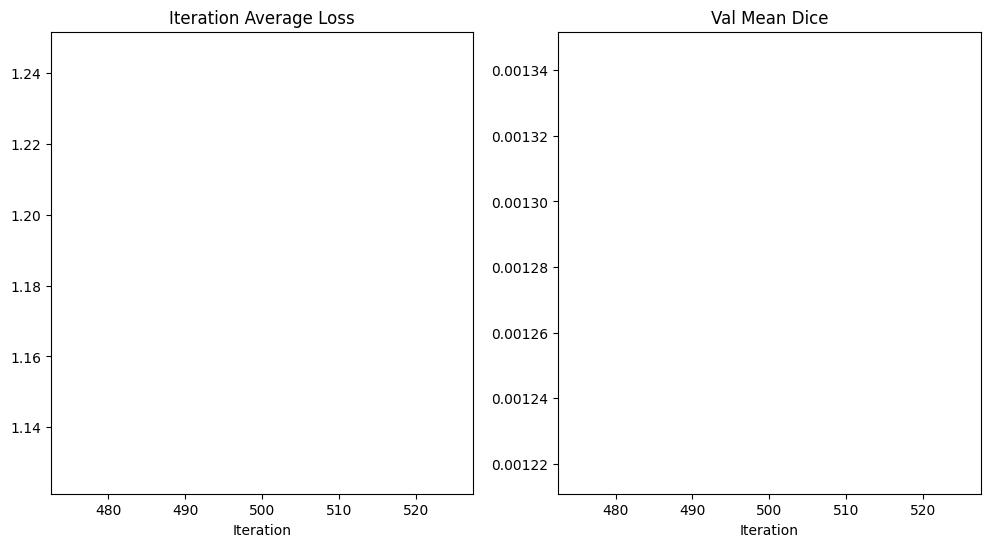

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(dsc_values))]
y = dsc_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
if personalize:
    loss_csv_path = os.path.join(results_dir, "epoch_loss_values_personalized_" + img_name + ".csv")
    metric_csv_path = os.path.join(results_dir, "metric_values_personalized_" + img_name + ".csv")

    model.load_state_dict(torch.load(os.path.join(results_dir, "best_metric_model_personalized_" + img_name + ".pth")))
else:
    loss_csv_path = os.path.join(results_dir, "epoch_loss_values.csv")
    metric_csv_path = os.path.join(results_dir, "metric_values.csv")

    model.load_state_dict(torch.load(os.path.join(results_dir, "best_metric_model.pth")))

# Save epoch loss values to CSV
with open(loss_csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Iteration", "Loss"])
    for i, loss in enumerate(epoch_loss_values):
        writer.writerow([eval_num * (i + 1), loss])

if personalize:
    # Save metric values to CSV  
    with open(metric_csv_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Iteration", "Uncertainty", "Dice Metric", "HD95 Metric", "MSD Metric"])
        for i, (std, dsc, hd95, msd) in enumerate(zip(std_values, dsc_values, hd95_values, msd_values)):
            writer.writerow([eval_num * (i + 1), std, dsc, hd95, msd])

# Initialize CSV file and write header  
with open(csv_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Case", "DSC"])

with torch.no_grad():
    epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
    
    for case_idx, batch in enumerate(epoch_iterator_val):

        val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            val_outputs = sliding_window_inference(
                val_inputs, size_patch, 4, model, overlap=0.5
            )

        # Post-processing
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        val_outputs_list = decollate_batch(val_outputs)
        softmax_output = torch.softmax(val_outputs_list[0], dim=0)
        val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

        # Calculate DSC 
        dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        case_dsc = dice_metric.aggregate().item()
        dice_metric.reset()

        # Save the results to a CSV file
        case_name = os.path.split(batch["image"].meta["filename_or_obj"][0])[1]
        with open(csv_path, mode="a", newline="") as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([case_name, case_dsc])

        print(f"\nSaved prediction for {case_name} with DSC: {case_dsc:.4f}")

        # # Save input 
        # input_data = val_inputs[0, 0].detach().cpu().numpy() 
        # affine = batch["image"].meta["affine"][0].cpu().numpy()
        # input_nifti = nib.Nifti1Image(input_data, affine)
        # input_path = os.path.join(results_dir, f"img{case_name.replace('.nii.gz', '').replace('img', '')}.nii.gz")
        # nib.save(input_nifti, input_path)

        # # Save label 
        # label_data = val_labels[0, 0].detach().cpu().numpy() 
        # label_nifti = nib.Nifti1Image(label_data, affine)
        # label_path = os.path.join(results_dir, f"label{case_name.replace('.nii.gz', '').replace('img', '')}.nii.gz")
        # nib.save(label_nifti, label_path)

        # # Save probability 
        # prob_volume = softmax_output.detach().cpu().numpy().astype(np.float32)
        # prob_nifti = nib.Nifti1Image(prob_volume, affine)
        # prob_path = os.path.join(results_dir, f"prob{case_name.replace('.nii.gz', '').replace('img', '')}.nii.gz")
        # nib.save(prob_nifti, prob_path)

        # # Save prediction 
        # single_volume = torch.argmax(softmax_output, dim=0).detach().cpu().numpy().astype(np.uint8)
        # prediction_nifti = nib.Nifti1Image(single_volume, affine)
        # prediction_path = os.path.join(results_dir, f"pred{case_name.replace('.nii.gz', '').replace('img', '')}.nii.gz")
        # nib.save(prediction_nifti, prediction_path)

print(f"Validation results saved to: {csv_path}")

# Note: Restore redirection to original state if necessary
log_file.close()
sys.stdout = sys.__stdout__
sys.stderr = sys.__stderr__

In [ ]:
# parser.add_argument("-postfix", type=str, default="", help="Postfix to append to the experiment name")

size_cache_test = 1 # 29
postfix = "do005"

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=False),
        EnsureChannelFirstd(keys=["image", "label"],channel_dim='no_channel'),
        ScaleIntensityRanged(keys=["image"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=dim_voxel,
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            keys=["image", "label"],
            spatial_size=size_patch,
            method="symmetric",
        ),
        EnsureTyped(keys=["image", "label"], device="cpu", track_meta=True),
        LambdaD(
            keys="label",
            func=make_fg_mask(fg_class)
        ),
    ]
)

test_dicts = load_decathlon_datalist(json_dir, True, "test")
test_ds = CacheDataset(data=test_dicts, transform=test_transforms, cache_num=size_cache_test, cache_rate=1.0, num_workers=4)
test_loader = ThreadDataLoader(test_ds, num_workers=0, batch_size=size_batch)

# Logs
if personalize:
    log_file_path = os.path.join(exp_path, "test_overfit.log")
else:
    log_file_path = os.path.join(exp_path, "test.log")
log_file = open(log_file_path, "w")

sys.stdout = log_file
sys.stderr = log_file

set_track_meta(True)

In [ ]:
model.load_state_dict(torch.load(os.path.join(exp_path, "results/best_metric_model.pth")))    
postfix_suffix = f"_{postfix}" if postfix else ""
results_dir = os.path.join(exp_path, f"results_test{postfix_suffix}")
csv_path = os.path.join(results_dir, "test_dsc.csv")

num_samples_mcd = 5
os.makedirs(results_dir, exist_ok=True)

# Initialize CSV file and write header  
with open(csv_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["Case", "Uncertainty", "DSC", "HD95", "MSD"]) 

In [ ]:
with torch.no_grad():
    epoch_iterator_val = tqdm(test_loader, desc="Test (X / X Steps) (dice=X.X)", dynamic_ncols=True)
    
    for case_idx, batch in enumerate(epoch_iterator_val):
        model.eval()
        enable_dropout(model)

        val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
        outputs_mc = []
        for _ in range(num_samples_mcd):
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(
                    val_inputs, size_patch, 4, model, overlap=0.5
                )
            outputs_mc.append(val_outputs)
        outputs_mc = torch.stack(outputs_mc, dim=0)
        outputs_mc = torch.softmax(outputs_mc, dim=2)
        uncertainty_map = outputs_mc.std(dim=0)
        val_uncertainty = uncertainty_map[0,1,:,:,:].mean().item()

        model.eval()
        with torch.cuda.amp.autocast():
            val_outputs = sliding_window_inference(
                val_inputs, size_patch, 4, model, overlap=0.5
            )

        # Post-processing
        val_labels_list = decollate_batch(val_labels)
        val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
        val_outputs_list = decollate_batch(val_outputs)
        softmax_output = torch.softmax(val_outputs_list[0], dim=0)
        val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]

        # Calculate metrics 
        dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        hd95_metric(y_pred=val_output_convert, y=val_labels_convert)
        msd_metric(y_pred=val_output_convert, y=val_labels_convert)
        
        case_dsc = dice_metric.aggregate().item()
        case_hd95 = hd95_metric.aggregate().item()
        case_msd = msd_metric.aggregate().item()

        dice_metric.reset()
        hd95_metric.reset()
        msd_metric.reset()

        # Save the results to a CSV file
        case_name = os.path.split(batch["image"].meta["filename_or_obj"][0])[1]
        with open(csv_path, mode="a", newline="") as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([case_name, val_uncertainty, case_dsc, case_hd95, case_msd])  

        # Save input 
        input_data = val_inputs[0, 0].detach().cpu().numpy()  
        affine = batch["image"].meta["affine"][0].cpu().numpy()
        input_nifti = nib.Nifti1Image(input_data, affine)
        input_path = os.path.join(results_dir, f"img{case_name.replace('.nii.gz', '').replace('img', '')}.nii.gz")
        nib.save(input_nifti, input_path)

        # Save label 
        label_data = val_labels[0, 0].detach().cpu().numpy()  
        label_nifti = nib.Nifti1Image(label_data, affine)
        label_path = os.path.join(results_dir, f"label{case_name.replace('.nii.gz', '').replace('img', '')}.nii.gz")
        nib.save(label_nifti, label_path)

        # Save probability 
        prob_volume = softmax_output.detach().cpu().numpy().astype(np.float32)
        prob_nifti = nib.Nifti1Image(prob_volume, affine)
        prob_path = os.path.join(results_dir, f"prob{case_name.replace('.nii.gz', '').replace('img', '')}.nii.gz")
        nib.save(prob_nifti, prob_path)

        # Save prediction 
        single_volume = torch.argmax(softmax_output, dim=0).detach().cpu().numpy().astype(np.uint8)
        prediction_nifti = nib.Nifti1Image(single_volume, affine)
        prediction_path = os.path.join(results_dir, f"pred{case_name.replace('.nii.gz', '').replace('img', '')}.nii.gz")
        nib.save(prediction_nifti, prediction_path)

        # Save MCD std map
        map_volume = uncertainty_map.detach().cpu().numpy().astype(np.float32)
        map_nifti = nib.Nifti1Image(map_volume, affine)
        map_path = os.path.join(results_dir, f"domap{case_name.replace('.nii.gz', '').replace('img', '')}.nii.gz")
        nib.save(map_nifti, map_path)

print(f"Test results saved to: {csv_path}")

# Note: Restore redirection to original state if necessary
log_file.close()
sys.stdout = sys.__stdout__
sys.stderr = sys.__stderr__

AttributeError: 'Tensor' object has no attribute 'meta'